In [74]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [75]:
sql_path = os.path.join('datasets', 'articles_data.csv')
df = pd.read_csv(sql_path, parse_dates=['published_at'])
df.drop(columns=['Unnamed: 0','source_id', 'url_to_image', 
                 'url', 'engagement_comment_plugin_count'], inplace=True)
df['month'] = df['published_at'].dt.month
df['day'] = df['published_at'].dt.dayofweek
df.head()

,source_name,author,title,description,published_at,content,top_article,engagement_reaction_count,engagement_comment_count,engagement_share_count,month,day
0,Reuters,Reuters Editorial,NTSB says Autopilot engaged in 2018 California...,The National Transportation Safety Board said ...,2019-09-03 16:22:20+00:00,WASHINGTON (Reuters) - The National Transporta...,0.0,0.0,0.0,2528.0,9.0,1.0
1,The Irish Times,Eoin Burke-Kennedy,Unemployment falls to post-crash low of 5.2%,Latest monthly figures reflect continued growt...,2019-09-03 10:32:28+00:00,The States jobless rate fell to 5.2 per cent l...,0.0,6.0,10.0,2.0,9.0,1.0
2,The Irish Times,Deirdre McQuillan,"Louise Kennedy AW2019: Long coats, sparkling t...",Autumn-winter collection features designer’s g...,2019-09-03 14:40:00+00:00,Louise Kennedy is showing off her autumn-winte...,1.0,NaN,NaN,NaN,9.0,1.0
3,Al Jazeera English,Al Jazeera,North Korean footballer Han joins Italian gian...,Han is the first North Korean player in the Se...,2019-09-03 17:25:39+00:00,"Han Kwang Song, the first North Korean footbal...",0.0,0.0,0.0,7.0,9.0,1.0
4,BBC News,BBC News,UK government lawyer says proroguing parliamen...,"The UK government's lawyer, David Johnston arg...",2019-09-03 14:39:21+00:00,NaN,0.0,0.0,0.0,0.0,9.0,1.0


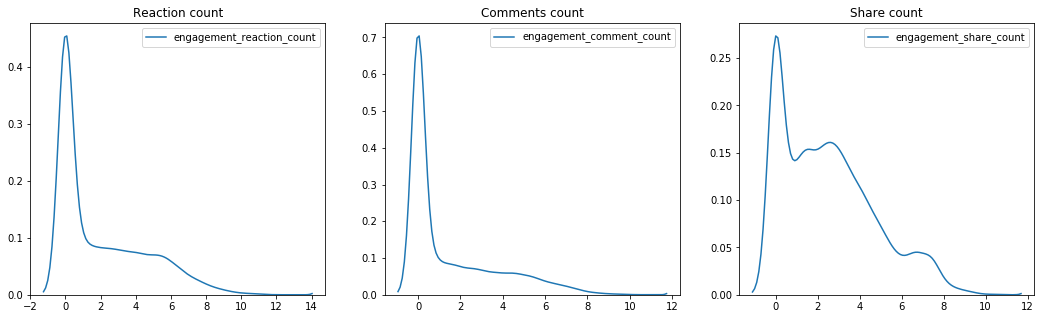

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ax1, ax2, ax3 = axes.flat
sns.kdeplot(np.log1p(df['engagement_reaction_count']), ax=ax1)
ax1.set_title('Reaction count')
sns.kdeplot(np.log1p(df['engagement_comment_count']), ax=ax2)
ax2.set_title('Comments count')
sns.kdeplot(np.log1p(df['engagement_share_count']), ax=ax3)
ax3.set_title('Share count');

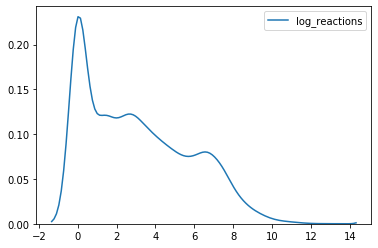

In [77]:
df['reactions'] = (df['engagement_reaction_count'] 
                   + df['engagement_comment_count']
                   + df['engagement_share_count'])
df.drop(columns=['engagement_reaction_count',
                 'engagement_comment_count',
                 'engagement_share_count'], 
        inplace=True)
df['log_reactions'] = np.log1p(df['reactions'])
sns.kdeplot(df['log_reactions'])

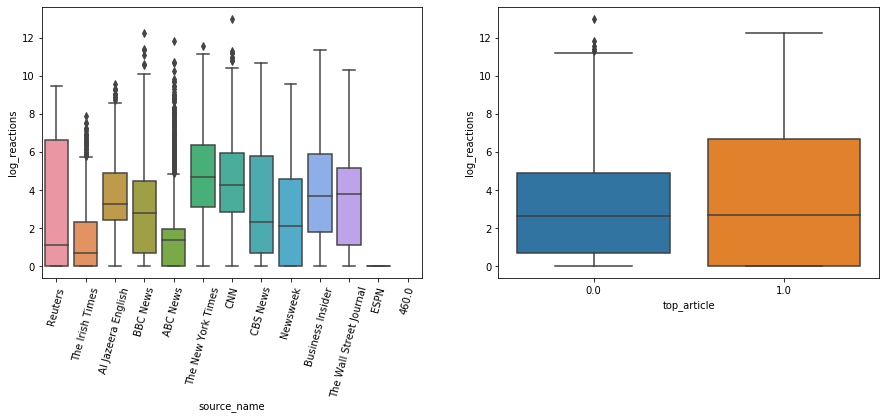

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x='source_name', y='log_reactions', data=df, ax=ax1)
ax1.xaxis.set_tick_params(rotation=75)
sns.boxplot(x='top_article', y='log_reactions', data=df, ax=ax2)

In [79]:
string_cols = ['source_name', 'author', 'title', 'description', 'content']
df[string_cols] = df[string_cols].fillna(' ')
df['text_content'] = (df['source_name'] + ' ' 
                      + df['author'] + ' ' 
                      + df['title'] + ' ' 
                      + df['description'] + ' '
                      + df['content'] + ' ')

### Machine learning

In [80]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers

In [81]:
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df['text_content'])
sequences = tokenizer.texts_to_sequences(df['text_content'])

In [82]:
maxlen = 300
text = pad_sequences(sequences, maxlen=maxlen)
labels = df['log_reactions']

In [85]:
model = models.Sequential()
model.add(layers.Embedding(2000, 100, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          200000    
_________________________________________________________________
flatten (Flatten)            (None, 30000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               7680256   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 7,